**Question 1:**

Select a dataset of you own choice of sufficient size, at least 500 rows, (prefer over a thousand rows), and at least 10 predictor attributes (prefer at least 20), and a target attribute. The target should be categorical.
Build a decision tree classifier for your data in Python, and select hyperparameters through the following steps:

*   Hold back 30% of your data for testing.
*   For the remaining data, use 5 fold cross validation to select hyperparameters.
*   In each fold, use the training data to predict the test data for values of hyperparameters.

Tasks to Complete:

1.  Provide your code.
2.  Plot the test error rate over each fold (5 points) versus hyperparameters. Comment on the value of hyperparameters selected and why you selected these. Consider error rate and complexity.
3.  Estimate the generalization error rate for your final model.

**Solution:**

**Understanding the data:**
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

**Data Source:** The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The data is downloaded from https://www.kaggle.com/henriqueyamahata/bank-marketing

**Attributes:** There are 20 attributes, some of which are categorical and others are numerical. The attributes are collected to have data about the following categories:

> **a) Bank Client Data:** This section has attributes like "Age", "Job", "Marital", "Education", "Default", "Housing", "Loan". The section provides knowledge about the clients characteristics.

> **b) Related with the last contact of the current campaign:** This section has attributes like, "Contact","Month","Day_of_week","Duration". These attributes provides information about the behavior of client during contact done during the last  contact

> **c) Other attributes:** Campaign, Pdays, Previous, Poutcome

> **d) Social and economic context attributes:** Emp.var.rate, Cons.price.idx, Cons.conf.idx, Euribor3m, Nr.employed

**Instances:** There are 40,000 instances of data

First, Lets Load all the required libraries and packages. 

In [0]:
from pandas_ml import ConfusionMatrix
import numpy as np
import pandas as pd
import pydotplus
#from google.colab import drive
from IPython.display import Image
from pylab import rcParams
from sklearn import metrics, preprocessing, tree
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from io import StringIO
import warnings
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from scipy import misc
from sklearn import tree
from matplotlib.pyplot import imread
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree

from sklearn.model_selection import cross_validate, KFold

# To support plots
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import math

# To display all the plots inline
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Binarizer

In [0]:
%matplotlib inline
rcParams['figure.figsize'] = 6, 6
warnings.filterwarnings("ignore")

Now, Here we load the data

In [0]:
bank_data = pd.read_csv('./bankadditionalfull.csv')

Before moving further to work on the data, we should understand the shape of the data and should check if it has any missing values to deal with the same.

In [0]:
#Total rows and columns in dataset
bank_data.shape

(41188, 21)

In [0]:
#Checking missing/null values
bank_data.isnull().values.any()

False

As it is clear, there are no missing values. Now as the data has a mix of categorical and numerical attributes, it is important to convert the categorical attributes to numerical format, based on the unique categories in each column, so that the model can be build on the whole data

In [0]:
bank_data["job"] = bank_data["job"].astype('category')
bank_data["marital"] = bank_data["marital"].astype('category')
bank_data["education"] = bank_data["education"].astype('category')
bank_data["default"] = bank_data["default"].astype('category')
bank_data["housing"] = bank_data["housing"].astype('category')
bank_data["loan"] = bank_data["loan"].astype('category')
bank_data["contact"] = bank_data["contact"].astype('category')
bank_data["month"] = bank_data["month"].astype('category')
bank_data["day_of_week"] = bank_data["day_of_week"].astype('category')
bank_data["poutcome"] = bank_data["poutcome"].astype('category')
bank_data["y"] = bank_data["y"].astype('category')

In [0]:
bank_data["job"] = bank_data["job"].cat.codes
bank_data["marital"] = bank_data["marital"].cat.codes
bank_data["education"] = bank_data["education"].cat.codes
bank_data["default"] = bank_data["default"].cat.codes
bank_data["housing"] = bank_data["housing"].cat.codes
bank_data["loan"] = bank_data["loan"].cat.codes
bank_data["contact"] = bank_data["contact"].cat.codes
bank_data["month"] = bank_data["month"].cat.codes
bank_data["day_of_week"] = bank_data["day_of_week"].cat.codes
bank_data["poutcome"] = bank_data["poutcome"].cat.codes
bank_data["y"] = bank_data["y"].cat.codes

bank_data.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,1,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,2,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,2,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [0]:
x = bank_data.iloc[:,0:20]
y = bank_data.iloc[:,20:21]
y.shape

(41188, 1)

Now as the data is converted to similar format. Let's do the first task, that is to hold the 30% amount of data for testing purpose i.e. in the vault which we will use later on to check the generalization error

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 123)
y_train = y_train.values
x_train = x_train.values
y_train.shape

(28831, 1)

In [0]:
class DummyScaler:
    def fit(self, data):
        pass
    def transform(self, data):
        return data
def create_scaler_dummy():
    return DummyScaler()    
def create_scaler_standard():
    return StandardScaler()
def create_scaler_minmax():
    return MinMaxScaler()
def crete_scaler_binarizer():
    return Binarizer()

Now, we can build the decision tree classifier using our training data as follows:

In [0]:
def create_plot_dt(_X, _y):
    x_train, y_train = _X, _y
    def plot_dt(max_depth=1, min_samples_split=2, expand=3.1):
        alpha=0.8
        model = DecisionTreeClassifier(max_depth=max_depth, 
                                       min_samples_split=min_samples_split,
                                       random_state=123)
                                       # class_weight='balanced')
        model.fit(x_train, y_train)        
        fig, ax2 = plt.subplots(1)
        annotations = plot_tree(model, ax=ax2, feature_names= [i for i in list(bank_data.columns) if i != 'y'], filled=True)
        for annotation in annotations:
            text = annotation.get_text()
            vals = text[text.rfind('[') + 1:]
            vals = vals[:vals.find(']')]
            vals = [float(x) for x in vals.split(',')]
            vals_sum = sum(vals)
            vals = [x / vals_sum for x in vals]
            annotation.set_color('w')
            # annotation.set_backgroundcolor(vals)
            plt.show()

    return plot_dt

The real time effect of changing the parameters can be understood by using the widgets as follows:

In [0]:
max_depth_widget = widgets.IntSlider(
    value=1,
    min=1,
    max=200,
    step=1,
    continuous_update=False,
    description='Max depth:')
min_samples_split_widget = widgets.IntSlider(
    value=2,
    min=2,
    max=20,
    step=1,
    continuous_update=False,
    description='Min Split:')
expand_widget = widgets.FloatSlider(
    value=0.0,
    min=0,
    max=1,
    step=0.1,
    continuous_update=False,
    description='Expand:')
interact(create_plot_dt(x_train, y_train), 
         max_depth=max_depth_widget, 
         min_samples_split=min_samples_split_widget,
         expand=expand_widget)

interactive(children=(IntSlider(value=1, continuous_update=False, description='Max depth:', max=200, min=1), I…

<function __main__.create_plot_dt.<locals>.plot_dt(max_depth=1, min_samples_split=2, expand=3.1)>

Now for the further task of cross validation, we can use the k-fold = 5. The following code also plots the relation of various hyperparameters with accuracy under each fold.

In [0]:
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
# definig yhat array with the no.of rows equal to x_train and 1 column
yhat = np.zeros((x_train.shape[0], ))

In [0]:
# K-fold Cross-validation
Max_depth = list()
List = list()

for max_depth in range(1,20):
    kfolds = list()
    for train, valid in kfold.split(x_train, y_train):
        
        model = DecisionTreeClassifier(max_depth=max_depth,random_state=123)
        model.fit(x_train[train], y_train[train])
        yhat[valid] = model.predict(x_train[valid])
        score = metrics.accuracy_score(y_train[valid], yhat[valid])
        kfolds.append(score)
        Max_depth.append(max_depth)

    List.append(kfolds)

In [0]:
print(List)

[[0.8876365528004162, 0.8822407214706902, 0.8900450919181409, 0.891605966007631, 0.8858827610128338], [0.9020287844633258, 0.8985431841831426, 0.9051335414498786, 0.9113770378078391, 0.9011446409989594], [0.907230795907751, 0.9051335414498786, 0.9096427332639612, 0.9183142559833507, 0.9058272632674298], [0.9098318016299636, 0.9068678459937565, 0.913111342351717, 0.9179673950745751, 0.9061741241762054], [0.9139934107855038, 0.9086021505376344, 0.9136316337148803, 0.9219562955254943, 0.9049601109954908], [0.914860412692908, 0.9091224419007978, 0.915539368713146, 0.9183142559833507, 0.9077349982656955], [0.9110456043003294, 0.909816163718349, 0.9117238987166146, 0.9200485605272286, 0.905653832813042], [0.9106988035373678, 0.9086021505376344, 0.9124176205341658, 0.9160596600763093, 0.9084287200832466], [0.9084445985781169, 0.908081859174471, 0.9112036073534513, 0.9160596600763093, 0.9084287200832466], [0.905149991329981, 0.9054804023586542, 0.9112036073534513, 0.9099895941727367, 0.9021852

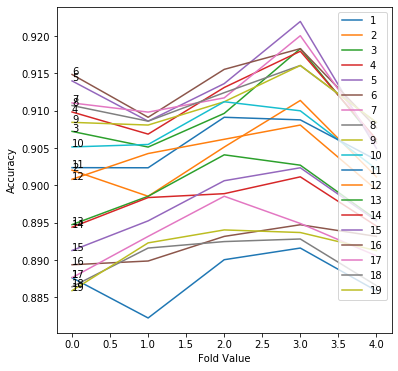

In [0]:
for i, value in enumerate(List):
    plt.plot(value, label=i+1)
    plt.legend()
    plt.text(0, value[0], i+1)
    plt.xlabel("Fold Value")
    plt.ylabel("Accuracy")
plt.savefig('figQ1.png')
plt.show()

In [0]:
# K-fold Cross-validation
Min_Sample_Split = list()
List = list()

for min_split in range(2,20):
    kfolds = list()
    for train, valid in kfold.split(x_train, y_train):
        
        model = DecisionTreeClassifier(max_depth=5, min_samples_split=min_split,random_state=123)
        model.fit(x_train[train], y_train[train])
        yhat[valid] = model.predict(x_train[valid])
        score = metrics.accuracy_score(y_train[valid], yhat[valid])
        kfolds.append(score)
        Min_Sample_Split.append(min_split)

    List.append(kfolds)

In [0]:
for i, value in enumerate(List):
    plt.plot(value, label=i+1)
    plt.legend()
    plt.text(0, value[0], i+1)
    plt.xlabel("Fold Value")
    plt.ylabel("Accuracy")
plt.savefig('figQ1.png')
plt.show()

We can also use grid Search to find out the best paramters from the given ranges.

In [0]:
from sklearn.model_selection import GridSearchCV

# parameter = { 'criterion':['gini','entropy'],'max_depth':range(1,20)}
parameter = [{'criterion': ['entropy', 'gini'], 'max_depth': range(1,20), 'min_samples_split': range(2,20)}]
               
#parameter = {'criterion':['gini','entropy'],'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150,200]}
# decision tree model
dt_model=DecisionTreeClassifier()

#use gridsearch to test all values with Kfold
dt_gscv = GridSearchCV(dt_model, parameter, cv=5)
    
#fit model to data
dt_gscv.fit(x_train[train], y_train[train])
tree_model = dt_gscv.best_estimator_
print ("Accuracy is:",dt_gscv.best_score_, dt_gscv.best_params_)
print(dt_gscv.best_estimator_)

Accuracy is: 0.9133318881422068 {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [0]:
for train, valid in kfold.split(x_train, y_train):
    model = DecisionTreeClassifier(max_depth=5,random_state=123)
    model.fit(x_train[train], y_train[train])
ypred = model.predict(x_test)

In [0]:
a = metrics.accuracy_score(y_test, ypred)
print("Accuracy of test data is:",a)

Accuracy of test data is: 0.9121955167111758


In [0]:
print("Generalization error is", 1-a)

Generalization error is 0.08780448328882418


In [0]:
model.fit(x_train, y_train) 
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.9134903293679696

In [0]:
print('Classification report:')
print(metrics.classification_report(y_test, ypred))

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10961
           1       0.66      0.45      0.54      1396

    accuracy                           0.91     12357
   macro avg       0.80      0.71      0.74     12357
weighted avg       0.90      0.91      0.90     12357



In [0]:
ypred = pd.DataFrame(ypred)
y_test = pd.DataFrame(y_test)
ypred = ypred.values.flatten()
y_test = y_test.values.flatten()

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False      10639   322    10961
True         763   633     1396
__all__    11402   955    12357
Stats:
population: 12357
P: 1396
N: 10961
PositiveTest: 955
NegativeTest: 11402
TP: 633
TN: 10639
FP: 322
FN: 763
TPR: 0.45343839541547276
TNR: 0.9706231183286197
PPV: 0.6628272251308901
NPV: 0.9330819154534292
FPR: 0.029376881671380348
FDR: 0.33717277486910996
FNR: 0.5465616045845272
ACC: 0.9121955167111758
F1_score: 0.5384942577626541
MCC: 0.5026948698864229
informedness: 0.4240615137440924
markedness: 0.5959091405843193
prevalence: 0.11297240430525209
LRP: 15.435211963195643
LRN: 0.5631038394445909
DOR: 27.41095137696084
FOR: 0.06691808454657078


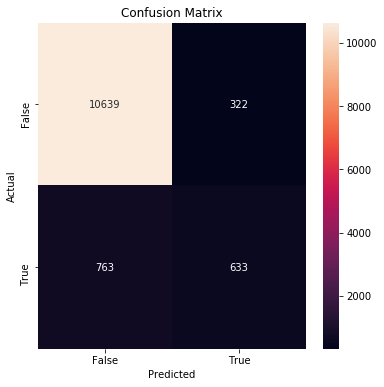

<Figure size 432x432 with 0 Axes>

In [0]:
from pandas_ml import ConfusionMatrix
print('Confusion matrix:')
cm = ConfusionMatrix(y_test, ypred)
print(cm)
print('Stats:')
cm.print_stats()
ax = cm.plot(backend='seaborn', annot=True, fmt='g')
ax.set_title('Confusion Matrix')
plt.show()
plt.clf()